In [177]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd
import netCDF4
%matplotlib inline

In [179]:
areacella1 = xr.open_dataset('areacella_fx_CanESM5_historical_r10i1p1f1_gn.nc').areacella
areacella2 = xr.open_dataset('areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_native.nc').areacella
areacella3 = xr.open_dataset('areacella_fx_CNRM-ESM2-1_historical_r10i1p1f2_gr.nc').areacella
areacella4 = xr.open_dataset('areacella_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc').areacella
areacella5 = xr.open_dataset('areacella_fx_MIROC-ES2L_historical_r10i1p1f2_gn.nc').areacella

In [180]:
landfrac1 = xr.open_dataset('sftlf_fx_CanESM5_ssp585_r1i1p1f1_gn.nc').sftlf
landfrac2 = xr.open_dataset('sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_native.nc').sftlf
landfrac3 = xr.open_dataset('sftlf_fx_CNRM-ESM2-1_historical_r10i1p1f2_gr.nc').sftlf
landfrac4 = xr.open_dataset('sftlf_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc').sftlf
landfrac5 = xr.open_dataset('sftlf_fx_MIROC-ES2L_historical_r1i1p1f2_gn.nc').sftlf

In [181]:
area1 = areacella1 * landfrac1/100
area2 = areacella2 * landfrac2/100
area3 = areacella3 * landfrac3/100
area4 = areacella4 * landfrac4/100
area5 = areacella5 * landfrac5/100

In [182]:
ds1 = xr.open_dataset('nbp_Lmon_CanESM5_hist_ssp119_r1i1p1f1_gn_185001-210012.nc')
ds2 = xr.open_dataset('nbp_Lmon_UKESM1-0-LL_hist_ssp119_r1i1p1f2_gn_185001-210012.nc')
ds3 = xr.open_dataset('nbp_Lmon_CNRM-ESM2-1_hist_ssp119_r1i1p1f2_gr_185001-210012.nc')
ds4 = xr.open_dataset('nbp_Lmon_IPSL-CM6A-LR_hist_ssp119_r1i1p1f1_gr_185001-210012.nc')
ds5 = xr.open_dataset('nbp_Lmon_MIROC-ES2L_hist_ssp119_r1i1p1f2_gn_185001-210012.nc')

In [183]:
dset_dict = {'CanESM5':ds1, 'UKESM1-0-LL':ds2, 'CNRM-ESM2-1':ds3, 'IPSL-CM6A-LR':ds4, 'MIROC-ES2L':ds5}

In [184]:
time_slice=slice('1850', '2100')

In [186]:
#initialize dictionary of xarray datasets
nbp_dict = {}

for name, ds in dset_dict.items():
        
    ds = xr.decode_cf(ds)
    ds = ds.sel(time=time_slice)
    
    # convert from per second to per year
    yearsec = 365*24*60*60
    ds.nbp.data = ds.nbp.data * yearsec
    
    #convert from kg to GtC
    ds.nbp.data = ds.nbp.data/(1e12)
    ds.nbp.attrs['units'] = 'GtC m-2 y-1'
    
    #nbp_mon=nbp_mon.sel(lon=slice(lon1,lon2), lat=slice(lat1,lat2))
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat', 'lon', 'time']:
            ds = ds.drop(coord)

    nbp_dict[name] = ds

In [188]:
glob1 = nbp_dict['CanESM5'].nbp.weighted(area1).sum(('lon','lat'))
glob2 = nbp_dict['UKESM1-0-LL'].nbp.weighted(area2).sum(('lon','lat'))
glob3 = nbp_dict['CNRM-ESM2-1'].nbp.weighted(area3).sum(('lon','lat'))
glob4 = nbp_dict['IPSL-CM6A-LR'].nbp.weighted(area4).sum(('lon','lat'))
glob5 = nbp_dict['MIROC-ES2L'].nbp.weighted(area5).sum(('lon','lat'))

In [189]:
gnbp_dict = {'CanESM5':glob1, 'UKESM1-0-LL':glob2,'CNRM-ESM2-1':glob3,
             'IPSL-CM6A-LR':glob4, 'MIROC-ES2L':glob5}

## Plotting Time Series: Changes in global mean nbp (1850-2100 wrt 1850-1900)

In [191]:
for name, gnbp in gnbp_dict.items():
    
    # drop redundant variables (like "type")
    for coord in gnbp.coords:
        if coord not in ['time']:
            gnbp = gnbp.drop(coord)
    
    # reference the GSAT relative to the 1850 to 1900 pre-industrial period
    gnbp_anomalies = gnbp - gnbp.sel(time=slice('1850','1900')).mean(dim='time')
    
    gnbp_ann_anomalies = gnbp_anomalies.groupby('time.year').mean('time')
        
    # renaming labels
    gnbp_ann_anomalies = gnbp_ann_anomalies.rename(
        r'Global-mean land carbon flux relative to 1850-1900 in GtC/yr'
    )
    
    gnbp_dict[name] = gnbp_ann_anomalies.compute()

In [192]:
gnbp_ann_anomalies.dims, gnbp_ann_anomalies.shape, gnbp_ann_anomalies.coords

(('year',),
 (251,),
 Coordinates:
   * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100)

In [193]:
gnbp1_roll = gnbp_dict['CanESM5'].rolling(year=10).mean()
gnbp2_roll = gnbp_dict['UKESM1-0-LL'].rolling(year=10).mean()
gnbp3_roll = gnbp_dict['CNRM-ESM2-1'].rolling(year=10).mean()
gnbp4_roll = gnbp_dict['IPSL-CM6A-LR'].rolling(year=10).mean()
gnbp5_roll = gnbp_dict['MIROC-ES2L'].rolling(year=10).mean()

modelmean = (gnbp1_roll + gnbp2_roll + gnbp3_roll + gnbp4_roll +gnbp5_roll)/5

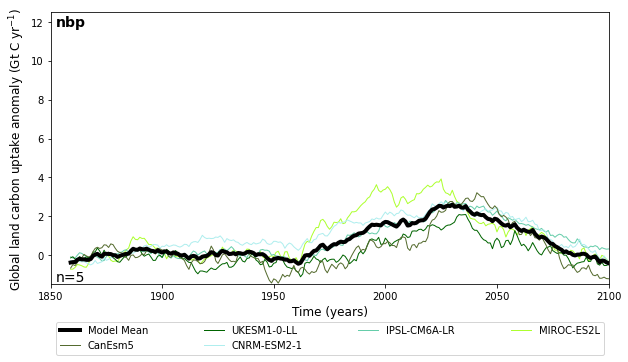

In [195]:
fig,ax = plt.subplots(figsize=(10,5))

gnbp5_roll.plot(ax=ax, linewidth=1, color= 'greenyellow', label='MIROC-ES2L')
gnbp4_roll.plot(ax=ax, linewidth=1, color= 'mediumaquamarine', label='IPSL-CM6A-LR')
gnbp3_roll.plot(ax=ax, linewidth=1, color= 'paleturquoise', label='CNRM-ESM2-1')
gnbp2_roll.plot(ax=ax, linewidth=1, color= 'darkgreen', label='UKESM1-0-LL')
gnbp1_roll.plot(ax=ax, linewidth=1, color= 'darkolivegreen', label='CanEsm5')

# adding model mean
modelmean.plot(ax=ax, linewidth=4, color= 'black', label= 'Model Mean')

#add right colors
#N = 5
#plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.RdYlGn(np.linspace(0,1,N)))

# set titel and name for axes
# plt.title('SSP1-1.9', fontsize = 14, fontweight = 'bold')
ax.text(0.01, 0.95, 'nbp', 
        transform=ax.transAxes, ha="left", fontsize= 14, fontweight = 'bold')
ax.text(0.009, 0.01, 'n=5', 
        transform=ax.transAxes, ha="left", fontsize= 14)
plt.xlabel('Time (years)', fontsize = 12)
plt.ylabel(r'Global land carbon uptake anomaly (Gt C yr$^{\minus1}$)', fontsize = 12)
plt.xlim([1850,2100])
plt.ylim([-1.5,12.5])


# plotting legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(0, -0.12, 1, 0), loc="upper left", mode="expand", ncol=4)

plt.savefig("TimeSeriesMultiModelCarbonChanges119.png", bbox_inches="tight")
plt.show();

In [196]:
max_nbp = max(modelmean)  # Find the maximum y value
max_year = modelmean[modelmean.argmax()]  # Find the x value corresponding to the maximum y value
print (max_year, max_nbp)

<xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' ()>
array(2.60008602)
Coordinates:
    year     int64 2030 <xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' ()>
array(nan)
Coordinates:
    year     int64 1850


In [197]:
modelmean.sel(year=slice('2025','2035'))

<xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' (year: 11)>
array([2.52854783, 2.44701131, 2.50591073, 2.54145593, 2.52113996,
       2.60008602, 2.48496272, 2.49940674, 2.54206587, 2.44745068,
       2.43598397])
Coordinates:
  * year     (year) int64 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035

In [198]:
modelmean.sel(year=slice('2025','2035')).mean()

<xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' ()>
array(2.50491107)

In [199]:
modelmean.sel(year=slice('2049','2059'))

<xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' (year: 11)>
array([1.87267976, 1.83908915, 1.73577464, 1.62630329, 1.5410945 ,
       1.51697795, 1.56945835, 1.43560342, 1.51661443, 1.58192181,
       1.41302332])
Coordinates:
  * year     (year) int64 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059

In [200]:
modelmean.sel(year=slice('2049','2059')).mean()

<xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' ()>
array(1.60441278)

In [201]:
modelmean.sel(year=slice('2090','2100'))

<xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' (year: 11)>
array([ 0.02616083, -0.09342596, -0.14793293, -0.10278044, -0.07034454,
       -0.21233474, -0.3730722 , -0.28716884, -0.29315247, -0.36943526,
       -0.41734137])
Coordinates:
  * year     (year) int64 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100

In [202]:
modelmean.sel(year=slice('2090','2100')).mean()

<xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' ()>
array(-0.21280254)

In [203]:
modelmean.sel(year=slice('2027','2037'))

<xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' (year: 11)>
array([2.50591073, 2.54145593, 2.52113996, 2.60008602, 2.48496272,
       2.49940674, 2.54206587, 2.44745068, 2.43598397, 2.52404233,
       2.33901415])
Coordinates:
  * year     (year) int64 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037

In [204]:
modelmean.sel(year=slice('2027','2037')).mean()

<xarray.DataArray 'Global-mean land carbon flux relative to 1850-1900 in GtC/yr' ()>
array(2.49468356)

# Plotting Maps of hottest model in ssp119: CanESM5

In [205]:
#initialize dictionary of xarray datasets
nbp_dict = {}

for name, ds in dset_dict.items():
        
    ds = xr.decode_cf(ds)
    ds = ds.sel(time=time_slice)
    
    # convert from per second to per year
    yearsec = 365*24*60*60
    ds.nbp.data = ds.nbp.data * yearsec
    
    #convert from kg to g
    ds.nbp.data = ds.nbp.data*(1e3)
    ds.nbp.attrs['units'] = 'g C m-2 y-1'
    
    #nbp_mon=nbp_mon.sel(lon=slice(lon1,lon2), lat=slice(lat1,lat2))
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat', 'lon', 'time']:
            ds = ds.drop(coord)

    nbp_dict[name] = ds

In [54]:
# selecting model out of dictionary
ssp_hot1 = nbp_dict[list(nbp_dict.keys())[0]]
ssp_hot1.attrs['parent_source_id']

'CanESM5'

In [56]:
# check units
ssp_hot1.nbp.attrs['units']

'g C m-2 y-1'

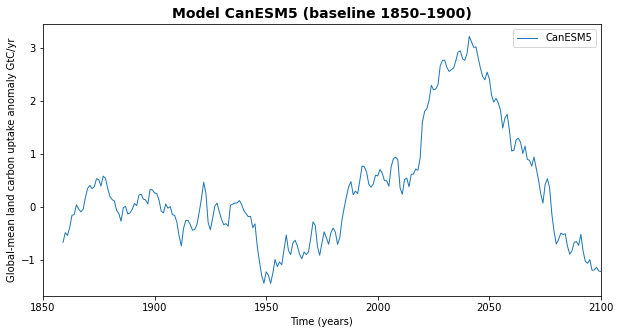

In [57]:
plt.figure(figsize=(10,5))

gnbp1_roll.plot(linewidth=1, label='%s' %(ssp_hot1.attrs['parent_source_id']))

# set titel and name for axes
plt.title('Model %s (baseline 1850–1900)' %(ssp_hot1.attrs['parent_source_id']),
         fontsize = 14, fontweight = 'bold')
plt.xlabel('Time (years)')
plt.ylabel(r'Global-mean land carbon uptake anomaly GtC/yr')
plt.xlim([1850,2100])

# plotting legend
plt.legend()
plt.savefig("CanESM5 Time Series NBP.png")
plt.show();

## Plotting nbp of CanESM5 at time of 1.5°C temperature (mean over 10 years)

In [58]:
carbon_flux = (
    ssp_hot1.nbp.sel(time=slice('2009', '2019')).mean(dim='time') -
    ssp_hot1.nbp.sel(time=slice('1850', '1900')).mean(dim='time')
).compute()
carbon_flux.attrs.update(ssp_hot1.attrs)
carbon_flux = carbon_flux.rename (
r'Δ C (gC m$^{\minus2}$)',
)

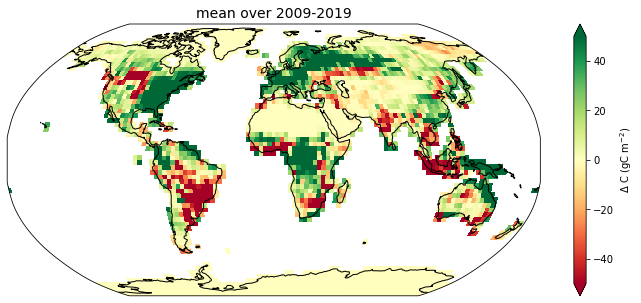

In [59]:
#choose projection: robinson projection
robin = ccrs.Robinson(central_longitude=0) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(12,5))
ax = plt.subplot(1, 1, 1, projection=robin)

#set min/max values for the colorbar
norm = mpl.colors.Normalize(vmin=-50, vmax=50)

q = carbon_flux.where(landfrac1>0).plot(ax=ax, cmap= 'RdYlGn', norm=norm, transform = geo) # plot a colormap in transformed coordinates

#add coastlines
ax.coastlines()

#Add title with the model name (parent_source_id is the model name, from the dataset attributes)
title = 'mean over 2009-2019'
plt.title(title, fontsize=14);

#save figure
plt.savefig("CanESM5 NBP Anomaly at 1.5C Global Map.png")

In [111]:
carbon_flux.sel(lat=slice(0,89)).weighted(area1).sum(('lon','lat'))/(1e15)

<xarray.DataArray 'Δ C (gC m$^{\\minus2}$)' ()>
array(1.20061633)
Coordinates:
    type     |S4 ...

## Plotting nbp of CanESM5 at time of 2.0°C temperature (mean over 10 years)

In [112]:
carbon_flux = (
    ssp_hot1.nbp.sel(time=slice('2024', '2034')).mean(dim='time') -
    ssp_hot1.nbp.sel(time=slice('1850', '1900')).mean(dim='time')
).compute()
carbon_flux.attrs.update(ssp_hot1.attrs)
carbon_flux = carbon_flux.rename (
r'Δ C (gC m$^{\minus2}$)'
)

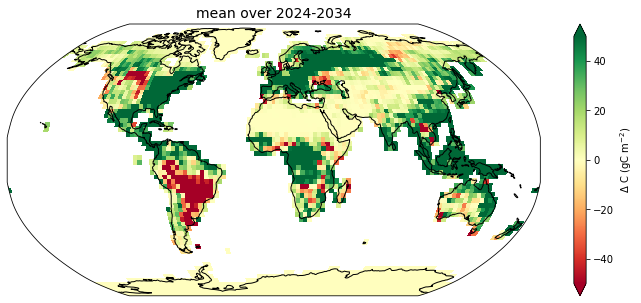

In [113]:
#choose projection: robinson projection
robin = ccrs.Robinson(central_longitude=0) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(12,5))
ax = plt.subplot(1, 1, 1, projection=robin)

#set min/max values for the colorbar
norm = mpl.colors.Normalize(vmin=-50, vmax=50)

q = carbon_flux.where(landfrac1>0).plot(ax=ax, cmap= 'RdYlGn', norm=norm, transform = geo) # plot a colormap in transformed coordinates

#add coastlines
ax.coastlines()

#Add title with the model name (parent_source_id is the model name, from the dataset attributes)
title = 'mean over 2024-2034' 
plt.title(title, fontsize=14);

#save figure
plt.savefig("CanESM5 NBP Anomaly at 2.0C Global Map.png")

In [143]:
carbon_flux.sel(lat=slice(0,-90)).weighted(area1).sum(('lon','lat'))/(1e15)

<xarray.DataArray 'Δ C (gC m$^{\\minus2}$)' ()>
array(0.)
Coordinates:
    type     |S4 ...

## Plotting nbp of CanESM5 at end-of-century wrt to pre-industrial

In [117]:
nbp_change = (
    ssp_hot1['nbp'].sel(time=slice('2080','2100')).mean(dim='time') -
    ssp_hot1['nbp'].sel(time=slice('1850','1900')).mean(dim='time')
).compute()
nbp_change.attrs.update(ssp_hot1.attrs)
nbp_change = nbp_change.rename(
    r'Δ C (gC m$^{\minus2}$)'
)

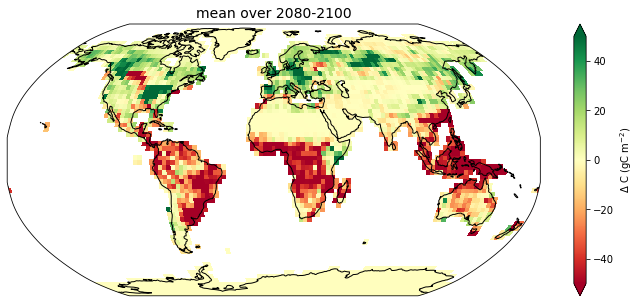

In [118]:
#choose projection: robinson projection
robin = ccrs.Robinson(central_longitude=0) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(12,5))
ax = plt.subplot(1, 1, 1, projection=robin)

#set min/max values for the colorbar
norm = mpl.colors.Normalize(vmin=-50, vmax=50)

q = nbp_change.where(landfrac1>0).plot(ax=ax,cmap= 'RdYlGn', norm=norm, transform = geo) # plot a colormap in transformed coordinates

#add coastlines
ax.coastlines()

#Add title with the model name (parent_source_id is the model name, from the dataset attributes)
title = 'mean over 2080-2100'
plt.title(title, fontsize=14);

#save figure
plt.savefig("CanESM5 NBP Anomaly end-of-century.png")

In [149]:
nbp_change.sel(lat=slice(0,90)).weighted(area1).sum(('lon','lat'))/(1e15)

<xarray.DataArray 'Δ C (gC m$^{\\minus2}$)' ()>
array(0.)
Coordinates:
    type     |S4 ...

# Plotting Maps of hot model in ssp119: UKESM1-0-LL

In [81]:
# selecting model out of dictionary
ssp_hot2 = nbp_dict[list(nbp_dict.keys())[1]]
ssp_hot2.attrs['parent_source_id']

'UKESM1-0-LL'

In [82]:
ssp_hot2

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 144, lon: 192, time: 3012)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    nbp        (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes: (12/48)
    Conventions:                CF-1.7 CMIP-6.2
    activity_id:                CMIP
    branch_method:              standard
    branch_time_in_child:       0.0
    branch_time_in_parent:      144000.0
    creation_date:              2019-06-24T12:28:55Z
    ...                         ...
    license:                    CMIP6 model data produced by the Met Office H...
    cmor_version:               3.4.0
    tracking_id:                hdl:21.14100/92fbbd01-cd9f-4a36-8989-00637a2a...
    NCO:                        netCDF Operators version 4.9.9 (Homepage = ht...
    history:                    Fri Jun  4 20:01:01 2021: ncks -A -v time nbp...
    history_of_appended_files:  Fri Jun  4 20:01:01 2021: Appended file nbp_L...

In [83]:
# check units
ssp_hot2.nbp.attrs['units']

'g C m-2 y-1'

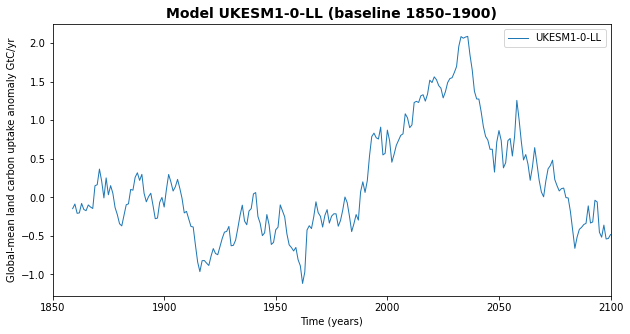

In [84]:
plt.figure(figsize=(10,5))

gnbp2_roll.plot(linewidth=1, label='%s' %(ssp_hot2.attrs['parent_source_id']))

# set titel (chanes in the net biome productivity) and name for axes
plt.title('Model %s (baseline 1850–1900)' %(ssp_hot2.attrs['parent_source_id']), 
         fontsize = 14, fontweight = 'bold')
plt.xlabel('Time (years)')
plt.ylabel(r'Global-mean land carbon uptake anomaly GtC/yr')
plt.xlim([1850,2100])

# plotting legend
plt.legend()
plt.savefig("UKESM1-0-LL Time Series NBP.png")
plt.show();

## Plotting nbp of UKESM1-0-LL at time of 1.5°C temperature (mean over 10 years)

In [85]:
carbon_flux = (
    ssp_hot2.nbp.sel(time=slice('2022', '2032')).mean(dim='time') -
    ssp_hot2.nbp.sel(time=slice('1850', '1900')).mean(dim='time')
).compute()
carbon_flux.attrs.update(ssp_hot2.attrs)
carbon_flux = carbon_flux.rename (
r'Δ C (gC m$^{\minus2}$)'
)

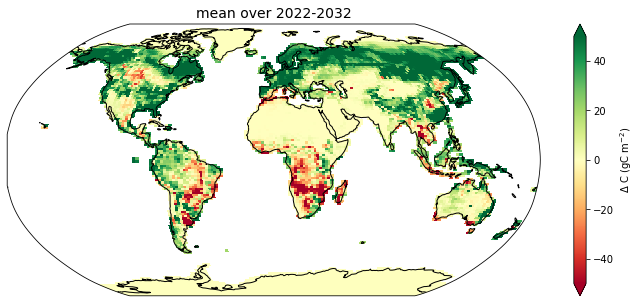

In [86]:
#choose projection: robinson projection
robin = ccrs.Robinson(central_longitude=0) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(12,5))
ax = plt.subplot(1, 1, 1, projection=robin)

#set min/max values for the colorbar
norm = mpl.colors.Normalize(vmin=-50, vmax=50)

q = carbon_flux.where(landfrac2>0).plot(ax=ax, cmap= 'RdYlGn', norm=norm, transform = geo) # plot a colormap in transformed coordinates

#add coastlines
ax.coastlines()

#Add title with the model name (parent_source_id is the model name, from the dataset attributes)
title = 'mean over 2022-2032'
plt.title(title,fontsize=14);

#save figure
plt.savefig("UKESM1-0-LL NBP Anomaly at 1.5C Global Map.png")

In [87]:
carbon_flux.sum()

<xarray.DataArray 'Δ C (gC m$^{\\minus2}$)' ()>
array(140834.33355285)

## Plotting nbp of UKESM1-0-LL at time of 2.0°C temperature (mean over 10 years)

In [92]:
carbon_flux = (
    ssp_hot2.nbp.sel(time=slice('2038', '2048')).mean(dim='time') -
    ssp_hot2.nbp.sel(time=slice('1850', '1900')).mean(dim='time')
).compute()
carbon_flux.attrs.update(ssp_hot2.attrs)
carbon_flux = carbon_flux.rename (
r'Δ C (gC m$^{\minus2}$)'
)

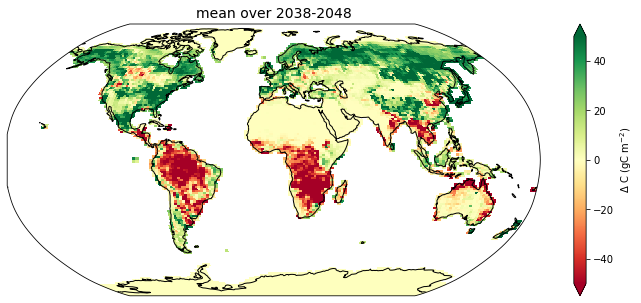

In [93]:
#choose projection: robinson projection
robin = ccrs.Robinson(central_longitude=0) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(12,5))
ax = plt.subplot(1, 1, 1, projection=robin)

#set min/max values for the colorbar
norm = mpl.colors.Normalize(vmin=-50, vmax=50)

q = carbon_flux.where(landfrac2>0).plot(ax=ax, cmap= 'RdYlGn', norm=norm, transform = geo) # plot a colormap in transformed coordinates

#add coastlines
ax.coastlines()

#Add title with the model name (parent_source_id is the model name, from the dataset attributes)
title = 'mean over 2038-2048'
plt.title(title, fontsize=14);

#save figure
plt.savefig("UKESM1-0-LL NBP Anomaly at 2.0C Global Map.png")

In [94]:
carbon_flux.sum()

<xarray.DataArray 'Δ C (gC m$^{\\minus2}$)' ()>
array(59796.23756142)

## Plotting nbp of UKESM1-0-LL at end-of-century wrt to pre-industrial

In [95]:
nbp_change = (
    ssp_hot2['nbp'].sel(time=slice('2080','2100')).mean(dim='time') -
    ssp_hot2['nbp'].sel(time=slice('1850','1900')).mean(dim='time')
).compute()
nbp_change.attrs.update(ssp_hot2.attrs)
nbp_change = nbp_change.rename(
    r'Δ C (gC m$^{\minus2}$)'
)

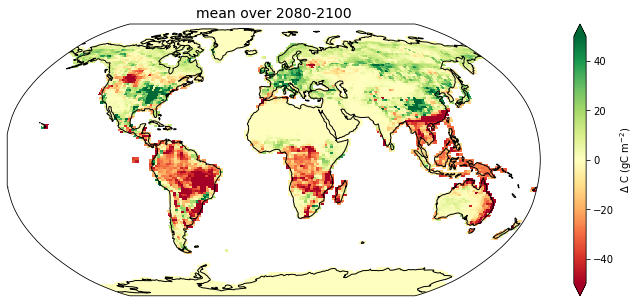

In [98]:
#choose projection: robinson projection
robin = ccrs.Robinson(central_longitude=0) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(12,5))
ax = plt.subplot(1, 1, 1, projection=robin)

#set min/max values for the colorbar
norm = mpl.colors.Normalize(vmin=-50, vmax=50)

q = nbp_change.where(landfrac2>0).plot(ax=ax,cmap= 'RdYlGn', norm=norm, transform = geo) # plot a colormap in transformed coordinates

#add coastlines
ax.coastlines()

#Add title with the model name (parent_source_id is the model name, from the dataset attributes)
title = 'mean over 2080-2100'
plt.title(title, fontsize=14);

#save figure
plt.savefig("UKESM1-0-LL nbp end of century global map.png")

In [99]:
nbp_change.sum()

<xarray.DataArray 'Δ C (gC m$^{\\minus2}$)' ()>
array(-10897.22895667)

# Plotting Maps of cold model in ssp119: MIROC-ES2L

In [207]:
# selecting model out of dictionary
ssp_cold1 = nbp_dict[list(nbp_dict.keys())[4]]
ssp_cold1.attrs['parent_source_id']

'MIROC-ES2L'

In [208]:
ssp_cold1

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 64, lon: 128, time: 3012)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    nbp        (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes: (12/46)
    Conventions:                CF-1.7 CMIP-6.2
    activity_id:                CMIP
    branch_method:              standard
    branch_time_in_child:       0.0
    branch_time_in_parent:      0.0
    creation_date:              2019-06-25T21:56:18Z
    ...                         ...
    license:                    CMIP6 model data produced by MIROC is license...
    cmor_version:               3.3.2
    tracking_id:                hdl:21.14100/c06da6c6-87c6-4acb-a3e0-74bcaa47...
    NCO:                        netCDF Operators version 4.9.9 (Homepage = ht...
    history:                    Fri Jun  4 20:00:50 2021: ncks -A -v time nbp...
    history_of_appended_files:  Fri Jun  4 20:00:50 2021: Appended file nbp_L...

In [209]:
# check units
ssp_cold1.nbp.attrs['units']

'g C m-2 y-1'

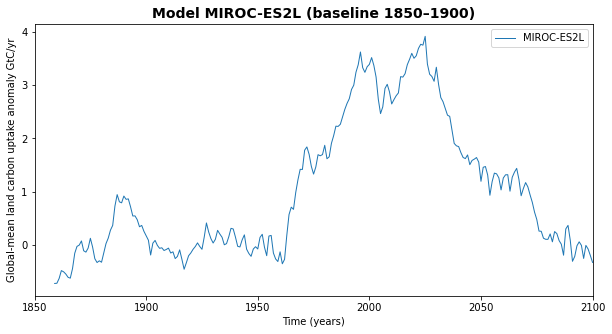

In [210]:
plt.figure(figsize=(10,5))

gnbp5_roll.plot(linewidth=1, label='%s' %(ssp_cold1.attrs['parent_source_id']))

# set titel (chanes in the net biome productivity) and name for axes
plt.title('Model %s (baseline 1850–1900)' %(ssp_cold1.attrs['parent_source_id']), 
         fontsize = 14, fontweight = 'bold')
plt.xlabel('Time (years)')
plt.ylabel(r'Global-mean land carbon uptake anomaly GtC/yr')
plt.xlim([1850,2100])

# plotting legend
plt.legend()
plt.savefig("MIROC-ES2L Time Series NBP.png")
plt.show();

## Plotting nbp of MIROC-ES2L at end-of-century wrt to pre-industrial

In [211]:
nbp_change = (
    ssp_cold1['nbp'].sel(time=slice('2080','2100')).mean(dim='time') -
    ssp_cold1['nbp'].sel(time=slice('1850','1900')).mean(dim='time')
).compute()
nbp_change.attrs.update(ssp_cold1.attrs)
nbp_change = nbp_change.rename(
    r'Δ C (gC m$^{\minus2}$)'
)

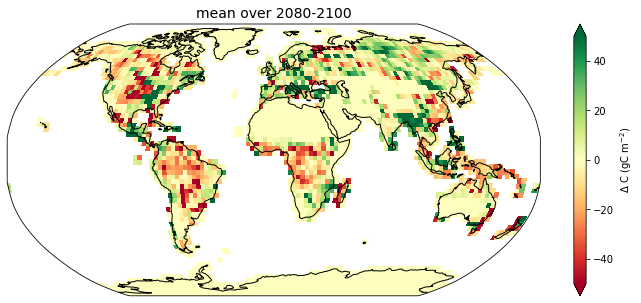

In [212]:
#choose projection: robinson projection
robin = ccrs.Robinson(central_longitude=0) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(12,5))
ax = plt.subplot(1, 1, 1, projection=robin)

#set min/max values for the colorbar
norm = mpl.colors.Normalize(vmin=-50, vmax=50)

q = nbp_change.where(landfrac5>0).plot(ax=ax,cmap= 'RdYlGn', norm=norm, transform = geo) # plot a colormap in transformed coordinates

#add coastlines
ax.coastlines()

#Add title with the model name (parent_source_id is the model name, from the dataset attributes)
title = 'mean over 2080-2100'
plt.title(title, fontsize=14);

#save figure
plt.savefig("MIROC-ES2L NBP Anomaly end-of-century.png")

In [149]:
nbp_change.sel(lat=slice(0,90)).weighted(area5).sum(('lon','lat'))/(1e15)

<xarray.DataArray 'Δ C (gC m$^{\\minus2}$)' ()>
array(0.)
Coordinates:
    type     |S4 ...

# Plotting Maps of cold model in ssp119:INM-CM4-8

In [ ]:
#No data available on the ETHZ-server.